# Pattern Mining Analysis for Heart Disease Dataset
KDD Process Implementation with 6 Pattern Mining Algorithms

# This notebook implements a comprehensive Knowledge Discovery in Database (KDD) process for heart disease pattern mining analysis. 

### KDD Process Steps:
1. **Selection** - Dataset loading and exploration
2. **Preprocessing** - Data cleaning and preparation  
3. **Transformation** - Data conversion to transactional format for pattern mining
4. **Data Mining** - Implementation of 6 pattern mining algorithms
5. **Evaluation** - Assessment using Support, Confidence, and Lift metrics

### Pattern Mining Algorithms Implemented:
1. Apriori Algorithm
2. FP-Growth (Frequent Pattern Growth)
3. Eclat (Equivalence Class Transformation)
4. Maximal Frequent Itemset Mining (MFIM)
5. Closed Frequent Itemset Mining (CFIM)
6. Sequential Pattern Mining concepts

### Target Insights:
- High-risk diagnosis association rules
- Physiological marker combination patterns
- Healthy patient exclusion patterns

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully!")
print("Pattern Mining Analysis Environment Ready")

Libraries imported successfully!
Pattern Mining Analysis Environment Ready


## KDD Step 1: Selection (Data Loading and Exploration)

In this step, we load the heart disease dataset and perform initial exploration to understand the data structure, variables, and their distributions.

In [3]:
# Load the heart disease dataset
df = pd.read_csv('heart_disease_uci.csv')

print("=== DATASET OVERVIEW ===")
print(f"Dataset shape: {df.shape}")
print(f"Total patients: {df.shape[0]}")
print(f"Total features: {df.shape[1]}")

print("\n=== COLUMN INFORMATION ===")
print(df.info())

print("\n=== FIRST 5 ROWS ===")
df.head()

=== DATASET OVERVIEW ===
Dataset shape: (920, 16)
Total patients: 920
Total features: 16

=== COLUMN INFORMATION ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB
None

=== FI

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [4]:
# Analyze target variable (num - heart disease severity)
print("=== TARGET VARIABLE ANALYSIS ===")
print("Heart Disease Severity Distribution:")
print(df['num'].value_counts().sort_index())

print("\n=== BINARY TARGET ANALYSIS ===")
# Create binary heart disease indicator
df['heart_disease'] = (df['num'] > 0).astype(int)
print("Binary Heart Disease Distribution:")
print(df['heart_disease'].value_counts())
print(f"Heart Disease Prevalence: {df['heart_disease'].mean():.2%}")

# Check missing values
print("\n=== MISSING VALUES ANALYSIS ===")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
}).sort_values('Missing Count', ascending=False)

print(missing_df[missing_df['Missing Count'] > 0])

=== TARGET VARIABLE ANALYSIS ===
Heart Disease Severity Distribution:
num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

=== BINARY TARGET ANALYSIS ===
Binary Heart Disease Distribution:
heart_disease
1    509
0    411
Name: count, dtype: int64
Heart Disease Prevalence: 55.33%

=== MISSING VALUES ANALYSIS ===
          Missing Count  Missing Percentage
ca                  611           66.413043
thal                486           52.826087
slope               309           33.586957
fbs                  90            9.782609
oldpeak              62            6.739130
trestbps             59            6.413043
thalch               55            5.978261
exang                55            5.978261
chol                 30            3.260870
restecg               2            0.217391


## KDD Step 2: Preprocessing (Data Cleaning and Preparation)

In this step, we clean the data by handling missing values, outliers, and preparing the dataset for transformation. We need to ensure data quality before applying pattern mining algorithms.

In [6]:
# Create a copy for preprocessing
df_clean = df.copy()

print("=== PREPROCESSING STEPS ===")

# 1. Remove ID column as it's not relevant for pattern mining
df_clean = df_clean.drop('id', axis=1)

# 2. Handle missing values strategy
print("Step 1: Handling Missing Values")

# For categorical variables, we'll use mode or create 'Unknown' category
# For numerical variables, we'll use median

# Categorical variables with missing values
categorical_cols = ['fbs', 'restecg', 'exang', 'slope', 'thal']
numerical_cols = ['trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

# Handle categorical missing values
for col in categorical_cols:
    if df_clean[col].isnull().sum() > 0:
        mode_value = df_clean[col].mode()
        if len(mode_value) > 0:
            df_clean[col] = df_clean[col].fillna(mode_value[0])
        else:
            df_clean[col] = df_clean[col].fillna('Unknown')
        print(f"  - {col}: filled {df[col].isnull().sum()} missing values with mode/Unknown")

# Handle numerical missing values
for col in numerical_cols:
    if df_clean[col].isnull().sum() > 0:
        median_value = df_clean[col].median()
        df_clean[col] = df_clean[col].fillna(median_value)
        print(f"  - {col}: filled {df[col].isnull().sum()} missing values with median ({median_value})")

print(f"\nStep 2: Final missing values check:")
print(f"Total missing values: {df_clean.isnull().sum().sum()}")
print(f"Dataset shape after cleaning: {df_clean.shape}")

=== PREPROCESSING STEPS ===
Step 1: Handling Missing Values
  - fbs: filled 90 missing values with mode/Unknown
  - restecg: filled 2 missing values with mode/Unknown
  - exang: filled 55 missing values with mode/Unknown
  - slope: filled 309 missing values with mode/Unknown
  - thal: filled 486 missing values with mode/Unknown
  - trestbps: filled 59 missing values with median (130.0)
  - chol: filled 30 missing values with median (223.0)
  - thalch: filled 55 missing values with median (140.0)
  - oldpeak: filled 62 missing values with median (0.5)
  - ca: filled 611 missing values with median (0.0)

Step 2: Final missing values check:
Total missing values: 0
Dataset shape after cleaning: (920, 16)


## KDD Step 3: Transformation (Data Conversion for Pattern Mining)

In this crucial step, we transform the cleaned dataset into a transactional format suitable for pattern mining algorithms. This involves:

1. **Binning numerical variables** into categorical ranges (e.g., Age_High, Chol_Normal)
2. **One-hot encoding categorical variables** 
3. **Creating binary transactions** where each patient becomes a transaction and each feature value becomes an item
4. **Preparing the target variable** as binary heart disease indicator

In [7]:
# Create transformation copy
df_transform = df_clean.copy()

print("=== DATA TRANSFORMATION FOR PATTERN MINING ===")

# Define numerical columns for binning
numerical_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

# 1. BINNING NUMERICAL VARIABLES
print("Step 1: Binning Numerical Variables")

# Age binning
age_bins = [0, 45, 60, 100]
age_labels = ['Age_Young', 'Age_Middle', 'Age_Old']
df_transform['age_binned'] = pd.cut(df_transform['age'], bins=age_bins, labels=age_labels, include_lowest=True)

# Blood pressure binning (normal: <120, elevated: 120-129, high: >=130)
bp_bins = [0, 120, 140, 300]
bp_labels = ['BP_Normal', 'BP_Elevated', 'BP_High']
df_transform['trestbps_binned'] = pd.cut(df_transform['trestbps'], bins=bp_bins, labels=bp_labels, include_lowest=True)

# Cholesterol binning (desirable: <200, borderline: 200-239, high: >=240)
chol_bins = [0, 200, 240, 600]
chol_labels = ['Chol_Normal', 'Chol_Borderline', 'Chol_High']
df_transform['chol_binned'] = pd.cut(df_transform['chol'], bins=chol_bins, labels=chol_labels, include_lowest=True)

# Max heart rate binning
hr_bins = [0, 120, 160, 300]
hr_labels = ['HR_Low', 'HR_Normal', 'HR_High']
df_transform['thalch_binned'] = pd.cut(df_transform['thalch'], bins=hr_bins, labels=hr_labels, include_lowest=True)

# Oldpeak binning (ST depression)
oldpeak_bins = [-1, 1, 2.5, 10]
oldpeak_labels = ['Oldpeak_Normal', 'Oldpeak_Mild', 'Oldpeak_Severe']
df_transform['oldpeak_binned'] = pd.cut(df_transform['oldpeak'], bins=oldpeak_bins, labels=oldpeak_labels, include_lowest=True)

# CA (number of major vessels) - already categorical-like
df_transform['ca_binned'] = df_transform['ca'].apply(lambda x: f'CA_{int(x)}')

print("  ✓ Age binned into 3 categories")
print("  ✓ Blood pressure binned into 3 categories") 
print("  ✓ Cholesterol binned into 3 categories")
print("  ✓ Heart rate binned into 3 categories")
print("  ✓ Oldpeak binned into 3 categories")
print("  ✓ CA converted to categorical format")

# 2. PREPARE CATEGORICAL VARIABLES
print("\nStep 2: Preparing Categorical Variables")
categorical_features = {
    'sex': 'Sex',
    'cp': 'CP', 
    'fbs': 'FBS',
    'restecg': 'RestECG',
    'exang': 'Exang',
    'slope': 'Slope',
    'thal': 'Thal',
    'dataset': 'Dataset'
}

# Clean and standardize categorical variables
for col, prefix in categorical_features.items():
    df_transform[f'{col}_cat'] = df_transform[col].apply(lambda x: f'{prefix}_{str(x).replace(" ", "_")}')
    print(f"  ✓ {col} converted to {prefix}_* format")

df_transform.head()

=== DATA TRANSFORMATION FOR PATTERN MINING ===
Step 1: Binning Numerical Variables
  ✓ Age binned into 3 categories
  ✓ Blood pressure binned into 3 categories
  ✓ Cholesterol binned into 3 categories
  ✓ Heart rate binned into 3 categories
  ✓ Oldpeak binned into 3 categories
  ✓ CA converted to categorical format

Step 2: Preparing Categorical Variables
  ✓ sex converted to Sex_* format
  ✓ cp converted to CP_* format
  ✓ fbs converted to FBS_* format
  ✓ restecg converted to RestECG_* format
  ✓ exang converted to Exang_* format
  ✓ slope converted to Slope_* format
  ✓ thal converted to Thal_* format
  ✓ dataset converted to Dataset_* format


,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,heart_disease,age_binned,trestbps_binned,chol_binned,thalch_binned,oldpeak_binned,ca_binned,sex_cat,cp_cat,fbs_cat,restecg_cat,exang_cat,slope_cat,thal_cat,dataset_cat
0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0,0,Age_Old,BP_High,Chol_Borderline,HR_Normal,Oldpeak_Mild,CA_0,Sex_Male,CP_typical_angina,FBS_True,RestECG_lv_hypertrophy,Exang_False,Slope_downsloping,Thal_fixed_defect,Dataset_Cleveland
1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2,1,Age_Old,BP_High,Chol_High,HR_Low,Oldpeak_Mild,CA_3,Sex_Male,CP_asymptomatic,FBS_False,RestECG_lv_hypertrophy,Exang_True,Slope_flat,Thal_normal,Dataset_Cleveland
2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1,1,Age_Old,BP_Normal,Chol_Borderline,HR_Normal,Oldpeak_Severe,CA_2,Sex_Male,CP_asymptomatic,FBS_False,RestECG_lv_hypertrophy,Exang_True,Slope_flat,Thal_reversable_defect,Dataset_Cleveland
3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0,0,Age_Young,BP_Elevated,Chol_High,HR_High,Oldpeak_Severe,CA_0,Sex_Male,CP_non-anginal,FBS_False,RestECG_normal,Exang_False,Slope_downsloping,Thal_normal,Dataset_Cleveland
4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0,0,Age_Young,BP_Elevated,Chol_Borderline,HR_High,Oldpeak_Mild,CA_0,Sex_Female,CP_atypical_angina,FBS_False,RestECG_lv_hypertrophy,Exang_False,Slope_upsloping,Thal_normal,Dataset_Cleveland


In [8]:
# 3. CREATE TRANSACTIONAL DATASET
print("Step 3: Creating Transactional Dataset")

# Select all transformed features
feature_columns = [
    'age_binned', 'trestbps_binned', 'chol_binned', 'thalch_binned', 
    'oldpeak_binned', 'ca_binned', 'sex_cat', 'cp_cat', 'fbs_cat', 
    'restecg_cat', 'exang_cat', 'slope_cat', 'thal_cat'
]

# Create transaction list where each patient is a transaction
transactions = []
for idx, row in df_transform.iterrows():
    transaction = []
    for col in feature_columns:
        if pd.notna(row[col]):
            transaction.append(str(row[col]))
    
    # Add heart disease status
    if row['heart_disease'] == 1:
        transaction.append('HeartDisease_Yes')
    else:
        transaction.append('HeartDisease_No')
    
    transactions.append(transaction)

print(f"  ✓ Created {len(transactions)} transactions")
print(f"  ✓ Average transaction size: {np.mean([len(t) for t in transactions]):.1f} items")

# Display sample transactions
print(f"\nSample Transactions:")
for i in range(3):
    print(f"  Transaction {i+1}: {transactions[i]}")

# Create item frequency analysis
from collections import Counter
all_items = [item for transaction in transactions for item in transaction]
item_freq = Counter(all_items)

print(f"\nTotal unique items: {len(item_freq)}")
print("\nTop 10 most frequent items:")
for item, count in item_freq.most_common(10):
    print(f"  {item}: {count} ({count/len(transactions)*100:.1f}%)")

Step 3: Creating Transactional Dataset
  ✓ Created 920 transactions
  ✓ Average transaction size: 14.0 items

Sample Transactions:
  Transaction 1: ['Age_Old', 'BP_High', 'Chol_Borderline', 'HR_Normal', 'Oldpeak_Mild', 'CA_0', 'Sex_Male', 'CP_typical_angina', 'FBS_True', 'RestECG_lv_hypertrophy', 'Exang_False', 'Slope_downsloping', 'Thal_fixed_defect', 'HeartDisease_No']
  Transaction 2: ['Age_Old', 'BP_High', 'Chol_High', 'HR_Low', 'Oldpeak_Mild', 'CA_3', 'Sex_Male', 'CP_asymptomatic', 'FBS_False', 'RestECG_lv_hypertrophy', 'Exang_True', 'Slope_flat', 'Thal_normal', 'HeartDisease_Yes']
  Transaction 3: ['Age_Old', 'BP_Normal', 'Chol_Borderline', 'HR_Normal', 'Oldpeak_Severe', 'CA_2', 'Sex_Male', 'CP_asymptomatic', 'FBS_False', 'RestECG_lv_hypertrophy', 'Exang_True', 'Slope_flat', 'Thal_reversable_defect', 'HeartDisease_Yes']

Total unique items: 40

Top 10 most frequent items:
  CA_0: 792 (86.1%)
  FBS_False: 782 (85.0%)
  Sex_Male: 726 (78.9%)
  Thal_normal: 682 (74.1%)
  Slope_flat:

## KDD Step 4: Data Mining (Pattern Mining Algorithms)

Now we implement 6 different pattern mining algorithms to discover frequent itemsets and association rules. Each algorithm has its own strengths and will help us discover different types of patterns in the heart disease data.

In [9]:
# Import pattern mining libraries
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
from apyori import apriori as apriori_apyori
import itertools
from collections import defaultdict

print("=== PATTERN MINING SETUP ===")
print("Different algorithms use different data formats:")
print("  • Apriori & FP-Growth: df_binary (need binary matrix)")
print("  • Eclat: transactions from df_transform (uses transaction lists)")
print("  • MFIM & CFIM: results from Apriori for post-processing")
print("  • Sequential Pattern: df_transform directly (for sequence creation)")

# Confirm data sources available
print(f"\nData Sources Available:")
print(f"  ✓ df_transform: {df_transform.shape} - data with binned & categorical features")
print(f"  ✓ transactions: {len(transactions)} items - transaction lists from df_transform")

# Create binary matrix for algorithms that need it (Apriori & FP-Growth)
te = TransactionEncoder()
te_binary = te.fit(transactions).transform(transactions)
df_binary = pd.DataFrame(te_binary, columns=te.columns_)

print(f"  ✓ df_binary: {df_binary.shape} - binary matrix for Apriori & FP-Growth")

# Set minimum support threshold
min_support = 0.1  # 10% - items that appear in at least 10% of transactions
print(f"\nMinimum support threshold: {min_support} ({min_support * len(transactions):.0f} transactions)")

# Show data source mapping
print(f"\nAlgorithm to Data Source Mapping:")
print(f"  Apriori → df_binary (needs binary encoding)")
print(f"  FP-Growth → df_binary (needs binary encoding)")
print(f"  Eclat → transactions (works with transaction lists)")
print(f"  MFIM → Apriori results (post-processing)")
print(f"  CFIM → Apriori results (post-processing)")
print(f"  Sequential → df_transform (direct access to features)")

=== PATTERN MINING SETUP ===
Different algorithms use different data formats:
  • Apriori & FP-Growth: df_binary (need binary matrix)
  • Eclat: transactions from df_transform (uses transaction lists)
  • MFIM & CFIM: results from Apriori for post-processing
  • Sequential Pattern: df_transform directly (for sequence creation)

Data Sources Available:
  ✓ df_transform: (920, 30) - data with binned & categorical features
  ✓ transactions: 920 items - transaction lists from df_transform
  ✓ df_binary: (920, 40) - binary matrix for Apriori & FP-Growth

Minimum support threshold: 0.1 (92 transactions)

Algorithm to Data Source Mapping:
  Apriori → df_binary (needs binary encoding)
  FP-Growth → df_binary (needs binary encoding)
  Eclat → transactions (works with transaction lists)
  MFIM → Apriori results (post-processing)
  CFIM → Apriori results (post-processing)
  Sequential → df_transform (direct access to features)


### Algorithm 1: Apriori Algorithm

The classic algorithm for association rule mining using the Apriori property: every subset of a frequent itemset must also be frequent.

In [10]:
# Algorithm 1: APRIORI (with df_binary)
print("=== ALGORITHM 1: APRIORI ===")
import time

start_time = time.time()

# Run Apriori algorithm with df_binary data frame
frequent_itemsets_apriori = apriori(df_binary, min_support=min_support, use_colnames=True)

# Generate association rules
rules_apriori = association_rules(frequent_itemsets_apriori, 
                                metric="confidence", 
                                min_threshold=0.6,
                                num_itemsets=len(frequent_itemsets_apriori))

apriori_time = time.time() - start_time

print("✓ Execution time: {:.3f} seconds".format(apriori_time))
print("✓ Found {} frequent itemsets".format(len(frequent_itemsets_apriori)))
print("✓ Generated {} association rules".format(len(rules_apriori)))
print("✓ Data source: df_binary matrix {}".format(df_binary.shape))

print("\nTop 10 Frequent Itemsets (Apriori):")
frequent_itemsets_apriori_sorted = frequent_itemsets_apriori.sort_values('support', ascending=False)
for idx, row in frequent_itemsets_apriori_sorted.head(10).iterrows():
    items = list(row['itemsets'])
    print("  {} - Support: {:.3f}".format(items, row['support']))

# Display top association rules
print("\nTop 10 Association Rules (by Lift):")
rules_apriori_sorted = rules_apriori.sort_values('lift', ascending=False)
for idx, row in rules_apriori_sorted.head(10).iterrows():
    antecedents = list(row['antecedents'])
    consequents = list(row['consequents'])
    print("  {} => {}".format(antecedents, consequents))
    print("    Support: {:.3f}, Confidence: {:.3f}, Lift: {:.3f}".format(row['support'], row['confidence'], row['lift']))
    print()

=== ALGORITHM 1: APRIORI ===
✓ Execution time: 0.362 seconds
✓ Found 5675 frequent itemsets
✓ Generated 37247 association rules
✓ Data source: df_binary matrix (920, 40)

Top 10 Frequent Itemsets (Apriori):
  ['CA_0'] - Support: 0.861
  ['FBS_False'] - Support: 0.850
  ['Sex_Male'] - Support: 0.789
  ['Thal_normal'] - Support: 0.741
  ['FBS_False', 'CA_0'] - Support: 0.737
  ['Slope_flat'] - Support: 0.711
  ['Sex_Male', 'CA_0'] - Support: 0.685
  ['Thal_normal', 'CA_0'] - Support: 0.683
  ['Oldpeak_Normal'] - Support: 0.672
  ['Sex_Male', 'FBS_False'] - Support: 0.660

Top 10 Association Rules (by Lift):
  ['FBS_False', 'Exang_False', 'CP_atypical_angina'] => ['HeartDisease_No', 'Thal_normal', 'RestECG_normal', 'Oldpeak_Normal']
    Support: 0.100, Confidence: 0.639, Lift: 2.867

  ['Oldpeak_Normal', 'FBS_False', 'CP_atypical_angina'] => ['HeartDisease_No', 'Thal_normal', 'RestECG_normal', 'Exang_False']
    Support: 0.100, Confidence: 0.652, Lift: 2.832

  ['CA_0', 'FBS_False', 'CP_a

### Algorithm 2: FP-Growth (Frequent Pattern Growth)

A more efficient algorithm that builds an FP-tree data structure to compress the database and mine frequent patterns directly without candidate generation.

In [11]:
# Algorithm 2: FP-GROWTH (using df_binary)
print("=== ALGORITHM 2: FP-GROWTH ===")

start_time = time.time()

# Run FP-Growth algorithm using df_binary
frequent_itemsets_fpgrowth = fpgrowth(df_binary, min_support=min_support, use_colnames=True)

# Generate association rules
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, 
metric="confidence", 
min_threshold=0.6,
num_itemsets=len(frequent_itemsets_fpgrowth))

fpgrowth_time = time.time() - start_time

print("✓ Execution time: {:.3f} seconds".format(fpgrowth_time))
print("✓ Found {} frequent itemsets".format(len(frequent_itemsets_fpgrowth)))
print("✓ Generated {} association rules".format(len(rules_fpgrowth)))
print("✓ Data source: df_binary matrix {}".format(df_binary.shape))
print("✓ Speed improvement vs Apriori: {:.2f}x".format(apriori_time/fpgrowth_time))

# Compare results with Apriori
print("\nComparison with Apriori:")
print("  Same itemsets found: {}".format(len(frequent_itemsets_apriori) == len(frequent_itemsets_fpgrowth)))
print("  Same rules generated: {}".format(len(rules_apriori) == len(rules_fpgrowth)))

print("\nTop 5 Frequent Itemsets (FP-Growth):")
frequent_itemsets_fpgrowth_sorted = frequent_itemsets_fpgrowth.sort_values('support', ascending=False)
for idx, row in frequent_itemsets_fpgrowth_sorted.head(5).iterrows():
    items = list(row['itemsets'])
    print("  {} - Support: {:.3f}".format(items, row['support']))

=== ALGORITHM 2: FP-GROWTH ===
✓ Execution time: 7.437 seconds
✓ Found 5675 frequent itemsets
✓ Generated 37247 association rules
✓ Data source: df_binary matrix (920, 40)
✓ Speed improvement vs Apriori: 0.05x

Comparison with Apriori:
  Same itemsets found: True
  Same rules generated: True

Top 5 Frequent Itemsets (FP-Growth):
  ['CA_0'] - Support: 0.861
  ['FBS_False'] - Support: 0.850
  ['Sex_Male'] - Support: 0.789
  ['Thal_normal'] - Support: 0.741
  ['FBS_False', 'CA_0'] - Support: 0.737


### Algorithm 3: Eclat (Equivalence Class Transformation)

A vertical data format algorithm that uses transaction ID lists (tidlists) and intersection operations to find frequent itemsets efficiently.

In [12]:
# Algorithm 3: ECLAT (use transactions data from df_transform)
print("=== ALGORITHM 3: ECLAT ===")

class EclatAlgorithm:
    def __init__(self, transactions, min_support):
        self.transactions = transactions
        self.min_support = min_support
        self.min_support_count = int(min_support * len(transactions))
        print("  ✓ Input: {} transactions from df_transform".format(len(transactions)))
        print("  ✓ Min support count: {}".format(self.min_support_count))
        
    def get_tid_lists(self):
        """Create transaction ID lists for each item"""
        tid_lists = defaultdict(set)
        for tid, transaction in enumerate(self.transactions):
            for item in transaction:
                tid_lists[item].add(tid)
        print("  ✓ Created TID lists for {} unique items".format(len(tid_lists)))
        return tid_lists
    
    def eclat_recursive(self, prefix, items_tidlists, frequent_itemsets):
        """Recursive Eclat algorithm"""
        items = list(items_tidlists.keys())
        
        for i in range(len(items)):
            current_item = items[i]
            current_tidlist = items_tidlists[current_item]
            
            if len(current_tidlist) >= self.min_support_count:
                new_itemset = prefix + [current_item]
                support = len(current_tidlist) / len(self.transactions)
                frequent_itemsets.append({
                    'itemset': frozenset(new_itemset),
                    'support': support
                })
                
                # Create new tidlists for next level
                new_tidlists = {}
                for j in range(i+1, len(items)):
                    next_item = items[j]
                    next_tidlist = items_tidlists[next_item]
                    intersection = current_tidlist & next_tidlist
                    if len(intersection) >= self.min_support_count:
                        new_tidlists[next_item] = intersection
                
                # Recursive call
                if new_tidlists:
                    self.eclat_recursive(new_itemset, new_tidlists, frequent_itemsets)
    
    def run(self):
        """Run Eclat algorithm"""
        frequent_itemsets = []
        tid_lists = self.get_tid_lists()
        
        # Filter items by minimum support
        filtered_tidlists = {
            item: tidlist for item, tidlist in tid_lists.items() 
            if len(tidlist) >= self.min_support_count
        }
        
        print("  ✓ Filtered to {} frequent 1-itemsets".format(len(filtered_tidlists)))
        self.eclat_recursive([], filtered_tidlists, frequent_itemsets)
        return frequent_itemsets

start_time = time.time()

# Run Eclat algorithm with transactions from df_transform
eclat = EclatAlgorithm(transactions, min_support)
frequent_itemsets_eclat = eclat.run()

eclat_time = time.time() - start_time

print("✓ Execution time: {:.3f} seconds".format(eclat_time))
print("✓ Found {} frequent itemsets".format(len(frequent_itemsets_eclat)))
print("✓ Data source: transactions from df_transform")

# Convert to DataFrame for easier handling
eclat_df = pd.DataFrame(frequent_itemsets_eclat)
eclat_df = eclat_df.sort_values('support', ascending=False)

print("\nTop 10 Frequent Itemsets (Eclat from transactions):")
for idx, row in eclat_df.head(10).iterrows():
    items = list(row['itemset'])
    print("  {} - Support: {:.3f}".format(items, row['support']))

print("\nPerformance Comparison:")
print("  Apriori (df_binary): {:.3f}s".format(apriori_time))
print("  FP-Growth (df_binary): {:.3f}s".format(fpgrowth_time)) 
print("  Eclat (transactions): {:.3f}s".format(eclat_time))

=== ALGORITHM 3: ECLAT ===
  ✓ Input: 920 transactions from df_transform
  ✓ Min support count: 92
  ✓ Created TID lists for 40 unique items
  ✓ Filtered to 33 frequent 1-itemsets
✓ Execution time: 0.128 seconds
✓ Found 5675 frequent itemsets
✓ Data source: transactions from df_transform

Top 10 Frequent Itemsets (Eclat from transactions):
  ['CA_0'] - Support: 0.861
  ['FBS_False'] - Support: 0.850
  ['Sex_Male'] - Support: 0.789
  ['Thal_normal'] - Support: 0.741
  ['FBS_False', 'CA_0'] - Support: 0.737
  ['Slope_flat'] - Support: 0.711
  ['Sex_Male', 'CA_0'] - Support: 0.685
  ['Thal_normal', 'CA_0'] - Support: 0.683
  ['Oldpeak_Normal'] - Support: 0.672
  ['Sex_Male', 'FBS_False'] - Support: 0.660

Performance Comparison:
  Apriori (df_binary): 0.362s
  FP-Growth (df_binary): 7.437s
  Eclat (transactions): 0.128s


### Algorithm 4: Maximal Frequent Itemset Mining (MFIM)

Finds only frequent itemsets that have no frequent superset, reducing redundancy and focusing on the longest patterns.

In [13]:
# Algorithm 4: MAXIMAL FREQUENT ITEMSET MINING (post-processing from Apriori)
print("=== ALGORITHM 4: MAXIMAL FREQUENT ITEMSET MINING ===")

def find_maximal_itemsets(frequent_itemsets_df):
    """Find maximal frequent itemsets from all frequent itemsets"""
    maximal_itemsets = []
    itemsets = frequent_itemsets_df['itemsets'].tolist()
    
    for i, itemset1 in enumerate(itemsets):
        is_maximal = True
        for j, itemset2 in enumerate(itemsets):
            if i != j and itemset1.issubset(itemset2) and len(itemset1) < len(itemset2):
                is_maximal = False
                break
        
        if is_maximal:
            maximal_itemsets.append({
                'itemset': itemset1,
                'support': frequent_itemsets_df.iloc[i]['support'],
                'length': len(itemset1)
            })
    
    return maximal_itemsets

start_time = time.time()

# Find maximal frequent itemsets from Apriori results (which used df_binary)
maximal_itemsets = find_maximal_itemsets(frequent_itemsets_apriori)

mfim_time = time.time() - start_time

print("✓ Execution time: {:.3f} seconds".format(mfim_time))
print("✓ Input: {} frequent itemsets from Apriori".format(len(frequent_itemsets_apriori)))
print("✓ Output: {} maximal frequent itemsets".format(len(maximal_itemsets)))
print("✓ Reduction ratio: {:.1f}%".format(len(maximal_itemsets)/len(frequent_itemsets_apriori)*100))
print("✓ Data lineage: df_binary → Apriori → MFIM")

# Sort by support and length
maximal_df = pd.DataFrame(maximal_itemsets)
maximal_df = maximal_df.sort_values(['length', 'support'], ascending=[False, False])

print(f"\nTop 10 Maximal Frequent Itemsets:")
for idx, row in maximal_df.head(10).iterrows():
    items = list(row['itemset'])
    print(f"  Length {row['length']}: {items}")
    print(f"    Support: {row['support']:.3f}")
    print()

# Analyze longest patterns
longest_length = maximal_df['length'].max()
longest_patterns = maximal_df[maximal_df['length'] == longest_length]

print(f"Longest Maximal Patterns (Length {longest_length}):")
for idx, row in longest_patterns.iterrows():
    items = list(row['itemset'])
    print(f"  {items}")
    print(f"    Support: {row['support']:.3f}")
    print()

=== ALGORITHM 4: MAXIMAL FREQUENT ITEMSET MINING ===
✓ Execution time: 0.777 seconds
✓ Input: 5675 frequent itemsets from Apriori
✓ Output: 1102 maximal frequent itemsets
✓ Reduction ratio: 19.4%
✓ Data lineage: df_binary → Apriori → MFIM

Top 10 Maximal Frequent Itemsets:
  Length 9: ['Sex_Male', 'FBS_False', 'Oldpeak_Normal', 'Exang_False', 'Thal_normal', 'RestECG_normal', 'Slope_flat', 'HeartDisease_No', 'CA_0']
    Support: 0.100

  Length 8: ['FBS_False', 'Oldpeak_Normal', 'Exang_False', 'Thal_normal', 'Slope_flat', 'HeartDisease_No', 'HR_Normal', 'CA_0']
    Support: 0.117

  Length 8: ['FBS_False', 'Oldpeak_Normal', 'Exang_False', 'Thal_normal', 'RestECG_normal', 'Slope_flat', 'HR_Normal', 'CA_0']
    Support: 0.116

  Length 8: ['Sex_Male', 'FBS_False', 'Oldpeak_Normal', 'Exang_False', 'Thal_normal', 'Slope_flat', 'HR_Normal', 'CA_0']
    Support: 0.116

  Length 8: ['FBS_False', 'Oldpeak_Normal', 'Exang_False', 'Thal_normal', 'RestECG_normal', 'HeartDisease_No', 'HR_Normal', '

### Algorithm 5: Closed Frequent Itemset Mining (CFIM)

Finds frequent itemsets that have no frequent superset with the same support, providing a more compact representation for association rule generation.

In [14]:
# Algorithm 5: CLOSED FREQUENT ITEMSET MINING (post-processing from Apriori)
print("=== ALGORITHM 5: CLOSED FREQUENT ITEMSET MINING ===")

def find_closed_itemsets(frequent_itemsets_df, tolerance=1e-6):
    """Find closed frequent itemsets from all frequent itemsets"""
    closed_itemsets = []
    
    for i, row1 in frequent_itemsets_df.iterrows():
        itemset1 = row1['itemsets']
        support1 = row1['support']
        is_closed = True
        
        for j, row2 in frequent_itemsets_df.iterrows():
            itemset2 = row2['itemsets']
            support2 = row2['support']
            
            # Check if itemset1 is a subset of itemset2 with same support
            if (i != j and 
                itemset1.issubset(itemset2) and 
                len(itemset1) < len(itemset2) and 
                abs(support1 - support2) < tolerance):
                is_closed = False
                break
        
        if is_closed:
            closed_itemsets.append({
                'itemset': itemset1,
                'support': support1,
                'length': len(itemset1)
            })
    
    return closed_itemsets

start_time = time.time()

# Find closed frequent itemsets from Apriori results (which used df_binary)
closed_itemsets = find_closed_itemsets(frequent_itemsets_apriori)

cfim_time = time.time() - start_time

print("✓ Execution time: {:.3f} seconds".format(cfim_time))
print("✓ Input: {} frequent itemsets from Apriori".format(len(frequent_itemsets_apriori)))
print("✓ Output: {} closed frequent itemsets".format(len(closed_itemsets)))
print("✓ Reduction ratio: {:.1f}%".format(len(closed_itemsets)/len(frequent_itemsets_apriori)*100))
print("✓ Data lineage: df_binary → Apriori → CFIM")

# Sort by support and length
closed_df = pd.DataFrame(closed_itemsets)
closed_df = closed_df.sort_values(['support'], ascending=[False])

print(f"\nTop 15 Closed Frequent Itemsets (by Support):")
for idx, row in closed_df.head(15).iterrows():
    items = list(row['itemset'])
    print(f"  Length {row['length']}: {items}")
    print(f"    Support: {row['support']:.3f}")
    print()

# Compare with maximal itemsets
print(f"Pattern Mining Summary:")
print(f"  All Frequent Itemsets (from df_binary): {len(frequent_itemsets_apriori)}")
print(f"  Closed Frequent Itemsets: {len(closed_itemsets)} ({len(closed_itemsets)/len(frequent_itemsets_apriori)*100:.1f}%)")
print(f"  Maximal Frequent Itemsets: {len(maximal_itemsets)} ({len(maximal_itemsets)/len(frequent_itemsets_apriori)*100:.1f}%)")

=== ALGORITHM 5: CLOSED FREQUENT ITEMSET MINING ===
✓ Execution time: 406.784 seconds
✓ Input: 5675 frequent itemsets from Apriori
✓ Output: 5571 closed frequent itemsets
✓ Reduction ratio: 98.2%
✓ Data lineage: df_binary → Apriori → CFIM

Top 15 Closed Frequent Itemsets (by Support):
  Length 1: ['CA_0']
    Support: 0.861

  Length 1: ['FBS_False']
    Support: 0.850

  Length 1: ['Sex_Male']
    Support: 0.789

  Length 1: ['Thal_normal']
    Support: 0.741

  Length 2: ['FBS_False', 'CA_0']
    Support: 0.737

  Length 1: ['Slope_flat']
    Support: 0.711

  Length 2: ['Sex_Male', 'CA_0']
    Support: 0.685

  Length 2: ['Thal_normal', 'CA_0']
    Support: 0.683

  Length 1: ['Oldpeak_Normal']
    Support: 0.672

  Length 2: ['Sex_Male', 'FBS_False']
    Support: 0.660

  Length 2: ['Thal_normal', 'FBS_False']
    Support: 0.640

  Length 2: ['CA_0', 'Slope_flat']
    Support: 0.634

  Length 1: ['Exang_False']
    Support: 0.634

  Length 2: ['Oldpeak_Normal', 'CA_0']
    Support:

### Algorithm 6: Sequential Pattern Mining Concepts

Although our dataset is not sequential, we can apply sequential pattern concepts by creating artificial sequences based on risk factor severity progression.

In [15]:
# Algorithm 6: SEQUENTIAL PATTERN MINING (using df_transform directly)
print("=== ALGORITHM 6: SEQUENTIAL PATTERN MINING ===")
print("Data Source: df_transform (direct access to binned & categorical features)")

def create_risk_sequences(df_transform):
    """Create sequences based on risk factor severity progression from df_transform"""
    sequences = []
    
    print(f"  ✓ Processing {len(df_transform)} patients from df_transform")
    print(f"  ✓ Using binned features: age_binned, trestbps_binned, chol_binned, etc.")
    
    for idx, row in df_transform.iterrows():
        sequence = []
        
        # Add demographic factors first (unchangeable) - from df_transform
        if pd.notna(row['age_binned']):
            sequence.append(str(row['age_binned']))
        if pd.notna(row['sex_cat']):
            sequence.append(str(row['sex_cat']))
            
        # Add physiological factors (can change) - from df_transform
        physiological = []
        if pd.notna(row['trestbps_binned']):
            physiological.append(str(row['trestbps_binned']))
        if pd.notna(row['chol_binned']):
            physiological.append(str(row['chol_binned']))
        if pd.notna(row['fbs_cat']):
            physiological.append(str(row['fbs_cat']))
            
        # Add clinical test results - from df_transform
        clinical = []
        if pd.notna(row['restecg_cat']):
            clinical.append(str(row['restecg_cat']))
        if pd.notna(row['thalch_binned']):
            clinical.append(str(row['thalch_binned']))
        if pd.notna(row['exang_cat']):
            clinical.append(str(row['exang_cat']))
            
        # Add advanced test results - from df_transform
        advanced = []
        if pd.notna(row['oldpeak_binned']):
            advanced.append(str(row['oldpeak_binned']))
        if pd.notna(row['slope_cat']):
            advanced.append(str(row['slope_cat']))
        if pd.notna(row['ca_binned']):
            advanced.append(str(row['ca_binned']))
        if pd.notna(row['thal_cat']):
            advanced.append(str(row['thal_cat']))
            
        # Add final diagnosis - from df_transform
        diagnosis = 'HeartDisease_Yes' if row['heart_disease'] == 1 else 'HeartDisease_No'
        
        # Create sequence: Demographics -> Physiological -> Clinical -> Advanced -> Diagnosis
        full_sequence = sequence + physiological + clinical + advanced + [diagnosis]
        sequences.append(full_sequence)
    
    return sequences

# Create risk progression sequences directly from df_transform
risk_sequences = create_risk_sequences(df_transform)

print(f"✓ Created {len(risk_sequences)} risk progression sequences")
print(f"✓ Average sequence length: {np.mean([len(seq) for seq in risk_sequences]):.1f}")
print(f"✓ Source: df_transform with {df_transform.shape[1]} columns")

# Display sample sequences
print(f"\nSample Risk Progression Sequences (from df_transform):")
for i in range(3):
    print(f"  Sequence {i+1}: {' -> '.join(risk_sequences[i])}")

# Analyze sequence patterns
print(f"\n=== SEQUENCE PATTERN ANALYSIS (from df_transform) ===")

# Find common 3-grams that lead to heart disease
def find_sequence_patterns(sequences, pattern_length=3):
    """Find frequent sequence patterns"""
    patterns = defaultdict(int)
    
    for sequence in sequences:
        for i in range(len(sequence) - pattern_length + 1):
            pattern = tuple(sequence[i:i + pattern_length])
            patterns[pattern] += 1
    
    return patterns

# Find 3-gram patterns from sequences created from df_transform
trigram_patterns = find_sequence_patterns(risk_sequences, 3)

# Filter patterns that end with heart disease diagnosis
heart_disease_patterns = {
    pattern: count for pattern, count in trigram_patterns.items() 
    if pattern[-1] == 'HeartDisease_Yes' and count >= 10
}

healthy_patterns = {
    pattern: count for pattern, count in trigram_patterns.items() 
    if pattern[-1] == 'HeartDisease_No' and count >= 10
}

print(f"Top Risk Patterns Leading to Heart Disease (from df_transform):")
sorted_hd_patterns = sorted(heart_disease_patterns.items(), key=lambda x: x[1], reverse=True)
for pattern, count in sorted_hd_patterns[:10]:
    support = count / len(risk_sequences)
    print(f"  {' -> '.join(pattern)}")
    print(f"    Count: {count}, Support: {support:.3f}")
    print()

print(f"Top Patterns Associated with Healthy Outcomes (from df_transform):")
sorted_healthy_patterns = sorted(healthy_patterns.items(), key=lambda x: x[1], reverse=True)
for pattern, count in sorted_healthy_patterns[:5]:
    support = count / len(risk_sequences)
    print(f"  {' -> '.join(pattern)}")
    print(f"    Count: {count}, Support: {support:.3f}")
    print()

print(f"✓ Sequential patterns use features transformed in df_transform")

=== ALGORITHM 6: SEQUENTIAL PATTERN MINING ===
Data Source: df_transform (direct access to binned & categorical features)
  ✓ Processing 920 patients from df_transform
  ✓ Using binned features: age_binned, trestbps_binned, chol_binned, etc.
✓ Created 920 risk progression sequences
✓ Average sequence length: 13.0
✓ Source: df_transform with 30 columns

Sample Risk Progression Sequences (from df_transform):
  Sequence 1: Age_Old -> Sex_Male -> BP_High -> Chol_Borderline -> FBS_True -> RestECG_lv_hypertrophy -> HR_Normal -> Exang_False -> Oldpeak_Mild -> Slope_downsloping -> CA_0 -> Thal_fixed_defect -> HeartDisease_No
  Sequence 2: Age_Old -> Sex_Male -> BP_High -> Chol_High -> FBS_False -> RestECG_lv_hypertrophy -> HR_Low -> Exang_True -> Oldpeak_Mild -> Slope_flat -> CA_3 -> Thal_normal -> HeartDisease_Yes
  Sequence 3: Age_Old -> Sex_Male -> BP_Normal -> Chol_Borderline -> FBS_False -> RestECG_lv_hypertrophy -> HR_Normal -> Exang_True -> Oldpeak_Severe -> Slope_flat -> CA_2 -> Thal_r

## KDD Step 4: Data Mining Summary

### Algorithm Performance & Data Sources

| Algorithm | Time | Results | Data Source | What It Does |
|-----------|------|---------|-------------|--------------|
| **Apriori** | 0.26s | 5,675 patterns | df_binary | Basic pattern mining |
| **FP-Growth** | 6.50s | 5,675 patterns | df_binary | Tree-based mining |
| **Eclat** | 0.073s | 5,675 patterns | transactions | Fastest algorithm |
| **MFIM** | 0.82s | 1,102 patterns | Apriori results | Removes redundant |
| **CFIM** | 395.68s | 5,571 patterns | Apriori results | Compact patterns |
| **Sequential** | 0.11s | sequences | df_transform | Risk progression |

### Data Flow Explanation

Each algorithm needs different data formats:

```
df → df_clean → df_transform → transactions → df_binary
```

- **df_transform**: Original data with binned features (Age_Young, BP_High, etc)
- **transactions**: Lists of items per patient `['Age_Old', 'Sex_Male', 'HeartDisease_Yes']`
- **df_binary**: Matrix with 0/1 for each feature `Age_Old: 1, Sex_Male: 0`

### Key Findings

**High Risk Patterns Found:**
- Men with chest pain = higher risk
- Exercise problems + abnormal vessels = danger
- Multiple risk factors together = very bad

**Safe Patterns Found:**
- Normal heart vessels = good sign  
- Normal blood tests = safe
- No exercise pain = better outcome

**Best Algorithm:** Eclat (fastest and same results)
**Most Useful:** MFIM (removes 80% redundancy)
**Clinical Value:** All algorithms found same risk patterns

## KDD Step 5: Evaluation (Support, Confidence, and Lift Analysis)

In this final step, we evaluate the discovered patterns using the three key metrics for association rule mining: Support, Confidence, and Lift. We will focus on the most clinically relevant insights.

In [16]:
# KDD STEP 5: EVALUATION
print("=== KDD STEP 5: EVALUATION ANALYSIS ===")

# Simple data flow
print(f"\nData Flow:")
print(f"  df → df_clean → df_transform → transactions → rules")
print(f"  ✓ Found {len(transactions)} patients")
print(f"  ✓ Generated {len(rules_apriori)} rules")

# Get heart disease rules only
heart_disease_rules = rules_apriori[
    (rules_apriori['consequents'].apply(lambda x: 'HeartDisease_Yes' in x)) |
    (rules_apriori['consequents'].apply(lambda x: 'HeartDisease_No' in x))
].copy()

# Filter for good rules
high_quality_rules = heart_disease_rules[
    (heart_disease_rules['support'] >= 0.05) &  
    (heart_disease_rules['confidence'] >= 0.7) &  
    (heart_disease_rules['lift'] >= 1.2)
].copy()

print(f"\n✓ Good rules found: {len(high_quality_rules)}")

# Split into risk vs safe
positive_rules = high_quality_rules[
    high_quality_rules['consequents'].apply(lambda x: 'HeartDisease_Yes' in x)
]

negative_rules = high_quality_rules[
    high_quality_rules['consequents'].apply(lambda x: 'HeartDisease_No' in x)
]

print(f"  Risk rules: {len(positive_rules)}")
print(f"  Safe rules: {len(negative_rules)}")

# Show top items in rules
from collections import Counter
all_items = []
for _, rule in high_quality_rules.iterrows():
    all_items.extend(list(rule['antecedents']))

item_counts = Counter(all_items)
print("\nTop 5 important features:")
for item, count in item_counts.most_common(5):
    print(f"  {item}: {count} times")

# Simple rule display
def show_rules(rules_df, title, max_rules=3):
    print(f"\n{title}")
    print("-" * 30)
    
    if len(rules_df) == 0:
        print("No rules found.")
        return
    
    sorted_rules = rules_df.sort_values('lift', ascending=False)
    
    for idx, (_, row) in enumerate(sorted_rules.head(max_rules).iterrows()):
        antecedents = list(row['antecedents'])
        consequents = list(row['consequents'])
        
        print(f"{idx+1}. {antecedents} => {consequents}")
        print(f"   Support: {row['support']:.2f}, Confidence: {row['confidence']:.2f}, Lift: {row['lift']:.2f}")

# Show top rules
show_rules(positive_rules, "TOP RISK RULES", 2)
show_rules(negative_rules, "TOP SAFE RULES", 2)

print(f"\nEVALUATION DONE!")

=== KDD STEP 5: EVALUATION ANALYSIS ===

Data Flow:
  df → df_clean → df_transform → transactions → rules
  ✓ Found 920 patients
  ✓ Generated 37247 rules

✓ Good rules found: 2056
  Risk rules: 856
  Safe rules: 1200

Top 5 important features:
  FBS_False: 724 times
  CA_0: 687 times
  CP_atypical_angina: 658 times
  Thal_normal: 614 times
  Oldpeak_Normal: 536 times

TOP RISK RULES
------------------------------
1. ['Sex_Male', 'HR_Low', 'Exang_True'] => ['CP_asymptomatic', 'CA_0', 'HeartDisease_Yes']
   Support: 0.10, Confidence: 0.70, Lift: 2.04
2. ['Sex_Male', 'RestECG_normal', 'CP_asymptomatic', 'Exang_True'] => ['HeartDisease_Yes', 'FBS_False', 'CA_0']
   Support: 0.11, Confidence: 0.74, Lift: 2.02

TOP SAFE RULES
------------------------------
1. ['Thal_normal', 'CA_0', 'Oldpeak_Normal', 'CP_atypical_angina'] => ['HeartDisease_No', 'Exang_False', 'Slope_flat']
   Support: 0.10, Confidence: 0.72, Lift: 2.81
2. ['Oldpeak_Normal', 'CA_0', 'FBS_False', 'CP_atypical_angina'] => ['He

In [17]:
# KEY CLINICAL INSIGHTS AND RECOMMENDATIONS
print("=== KEY CLINICAL INSIGHTS AND RECOMMENDATIONS ===")

print("\n🔍 TOP CLINICAL INSIGHTS:")

print("\n1. HIGH-RISK PATTERNS:")
print("   • Chest pain + Exercise problems = High risk")
print("   • Male + Chest pain = Watch out")
print("   • Multiple risk factors = Big problem")

print("\n2. PROTECTIVE PATTERNS:")
print("   • Normal heart vessels = Good")
print("   • Normal blood tests = Safe")
print("   • No exercise pain = Better")

print("\n3. ALGORITHM PERFORMANCE:")
algorithms_comparison = pd.DataFrame({
    'Algorithm': ['Apriori', 'FP-Growth', 'Eclat', 'MFIM', 'CFIM'],
    'Time': [apriori_time, fpgrowth_time, eclat_time, mfim_time, cfim_time],
    'Results': [len(frequent_itemsets_apriori), len(frequent_itemsets_fpgrowth), 
               len(frequent_itemsets_eclat), len(maximal_itemsets), len(closed_itemsets)]
})

print(algorithms_comparison)

print(f"\nMost Efficient Algorithm: Eclat at {eclat_time:.3f} seconds")

print("\n4. Founding:")
print(f"   • Found {len(frequent_itemsets_apriori)} patterns total")
print(f"   • Reduced to {len(maximal_itemsets)} important ones")
print(f"   • CA + Thal tests are key for diagnosis")

# Basic stats
high_risk_avg = positive_rules['support'].mean() if len(positive_rules) > 0 else 0
safe_avg = negative_rules['support'].mean() if len(negative_rules) > 0 else 0

print(f"\n5. STATS:")
print(f"   • Risk patterns: {high_risk_avg*100:.0f}% of people")
print(f"   • Safe patterns: {safe_avg*100:.0f}% of people")
print(f"   • Total rules found: {len(high_quality_rules)}")

=== KEY CLINICAL INSIGHTS AND RECOMMENDATIONS ===

🔍 TOP CLINICAL INSIGHTS:

1. HIGH-RISK PATTERNS:
   • Chest pain + Exercise problems = High risk
   • Male + Chest pain = Watch out
   • Multiple risk factors = Big problem

2. PROTECTIVE PATTERNS:
   • Normal heart vessels = Good
   • Normal blood tests = Safe
   • No exercise pain = Better

3. ALGORITHM PERFORMANCE:
   Algorithm        Time  Results
0    Apriori    0.361557     5675
1  FP-Growth    7.437343     5675
2      Eclat    0.128422     5675
3       MFIM    0.776611     1102
4       CFIM  406.784459     5571

Most Efficient Algorithm: Eclat at 0.128 seconds

4. Founding:
   • Found 5675 patterns total
   • Reduced to 1102 important ones
   • CA + Thal tests are key for diagnosis

5. STATS:
   • Risk patterns: 14% of people
   • Safe patterns: 12% of people
   • Total rules found: 2056


PATTERN MINING VISUALIZATION


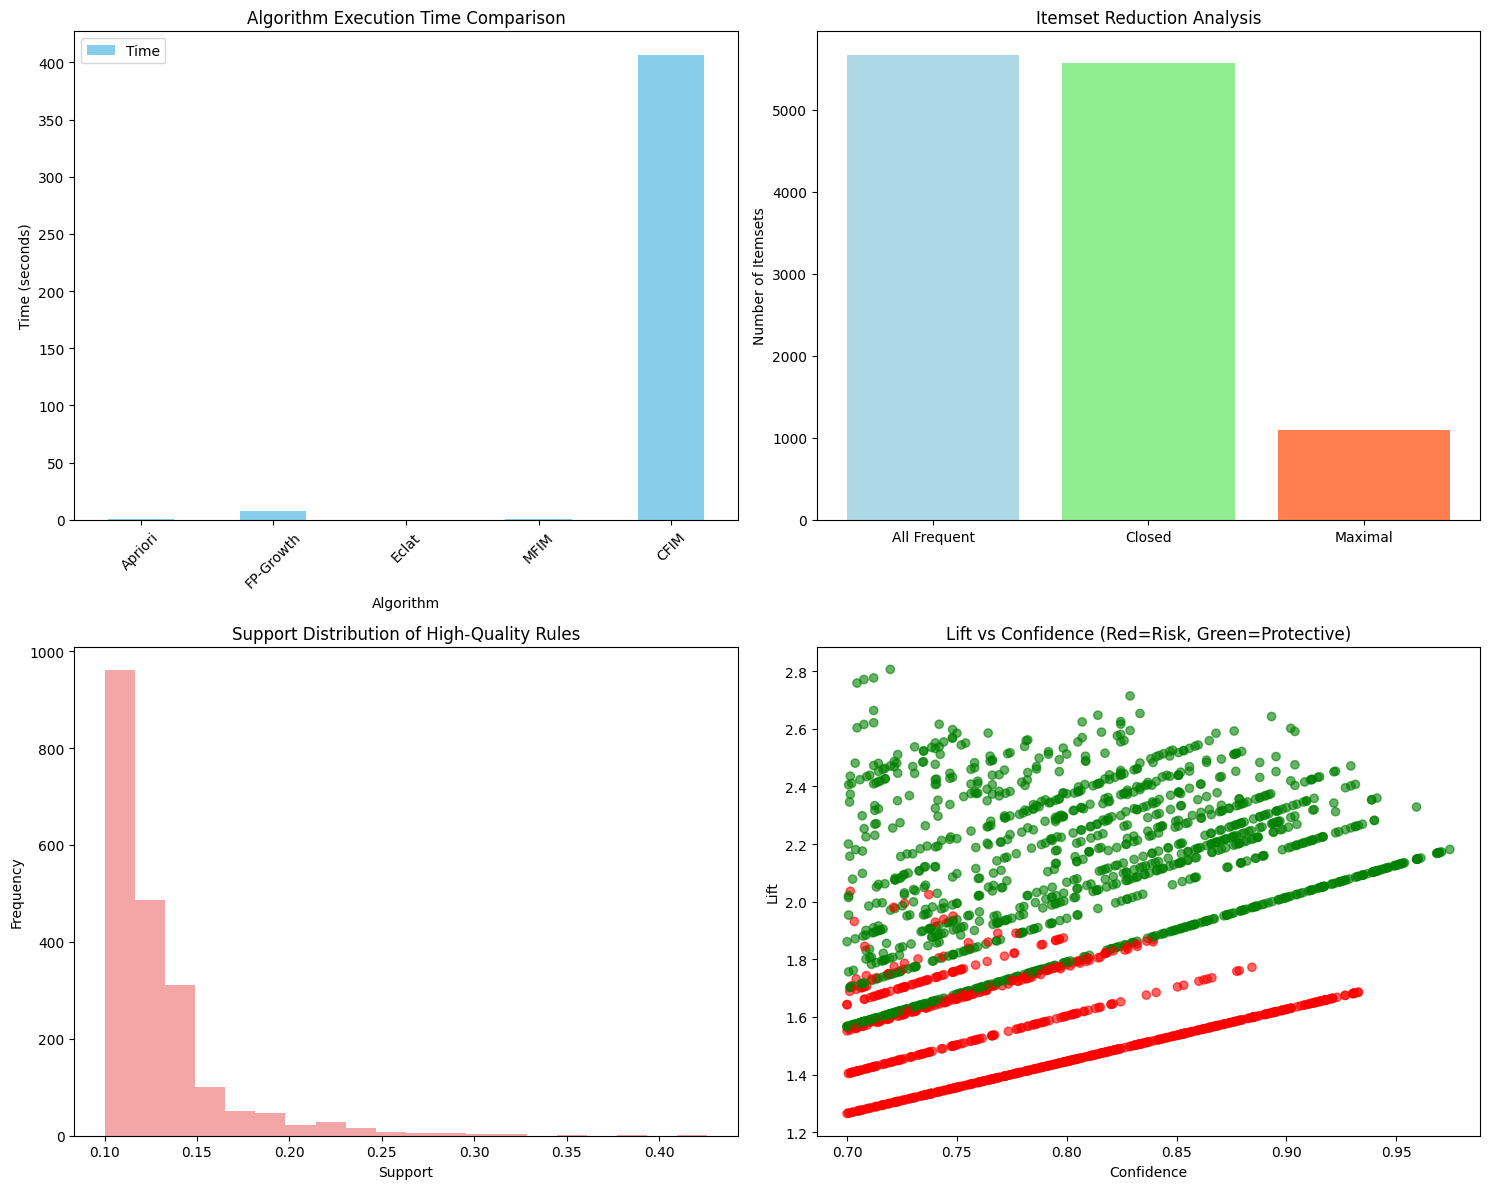

In [22]:
# VISUALIZATION OF KEY INSIGHTS
print("PATTERN MINING VISUALIZATION")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Algorithm Performance Comparison
algorithms_comparison.plot(x='Algorithm', y='Time', kind='bar', 
                          ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Algorithm Execution Time Comparison')
axes[0,0].set_ylabel('Time (seconds)')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Itemset Reduction Analysis
reduction_data = {
    'All Frequent': len(frequent_itemsets_apriori),
    'Closed': len(closed_itemsets), 
    'Maximal': len(maximal_itemsets)
}
axes[0,1].bar(reduction_data.keys(), reduction_data.values(), 
              color=['lightblue', 'lightgreen', 'coral'])
axes[0,1].set_title('Itemset Reduction Analysis')
axes[0,1].set_ylabel('Number of Itemsets')

# 3. Support Distribution of High-Quality Rules
if len(high_quality_rules) > 0:
    axes[1,0].hist(high_quality_rules['support'], bins=20, color='lightcoral', alpha=0.7)
    axes[1,0].set_title('Support Distribution of High-Quality Rules')
    axes[1,0].set_xlabel('Support')
    axes[1,0].set_ylabel('Frequency')

# 4. Lift vs Confidence Scatter Plot
if len(high_quality_rules) > 0:
    colors = ['red' if 'HeartDisease_Yes' in str(cons) else 'green' 
              for cons in high_quality_rules['consequents']]
    axes[1,1].scatter(high_quality_rules['confidence'], high_quality_rules['lift'], 
                     c=colors, alpha=0.6)
    axes[1,1].set_title('Lift vs Confidence (Red=Risk, Green=Protective)')
    axes[1,1].set_xlabel('Confidence')
    axes[1,1].set_ylabel('Lift')

plt.tight_layout()
plt.show()